In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from collections import defaultdict

%matplotlib inline

## 1. Load Test Puzzle Data

In [2]:
# Configuration - Test multiple images
PUZZLE_TYPE = "puzzle_2x2"
IMAGE_IDS = ["0", "1", "2"]  # Test multiple images

print(f"Testing puzzle type: {PUZZLE_TYPE}")
print(f"Number of images to test: {len(IMAGE_IDS)}")
print(f"Image IDs: {IMAGE_IDS}")

Testing puzzle type: puzzle_2x2
Number of images to test: 3
Image IDs: ['0', '1', '2']


In [3]:
# Process all images
all_results = []

for IMAGE_ID in IMAGE_IDS:
    ARTIFACT_DIR = f"./processed_artifacts/{PUZZLE_TYPE}/image_{IMAGE_ID}"
    
    # Load metadata
    with open(f"{ARTIFACT_DIR}/metadata.json", 'r') as f:
        metadata = json.load(f)
    
    grid_size = metadata['grid_size']
    num_pieces = metadata['num_pieces']
    
    # Load original patches
    original_patches = []
    for i in range(num_pieces):
        original_path = metadata['image_path']
        original_img = cv2.imread(original_path)
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        height, width = original_img_rgb.shape[:2]
        patch_h = height // grid_size
        patch_w = width // grid_size
        
        row = i // grid_size
        col = i % grid_size
        
        patch = original_img_rgb[row*patch_h:(row+1)*patch_h, col*patch_w:(col+1)*patch_w]
        original_patches.append(patch)
    
    # Load edge images
    edge_images = []
    for i in range(num_pieces):
        edge_path = f"{ARTIFACT_DIR}/edge_images/piece_{i:02d}_edges.png"
        edge_img = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)
        edge_images.append(edge_img)
    
    all_results.append({
        'image_id': IMAGE_ID,
        'metadata': metadata,
        'grid_size': grid_size,
        'num_pieces': num_pieces,
        'original_patches': original_patches,
        'edge_images': edge_images
    })
    
    print(f"Loaded Image {IMAGE_ID}: {num_pieces} pieces ({grid_size}x{grid_size})")

print(f"\nTotal images loaded: {len(all_results)}")

Loaded Image 0: 4 pieces (2x2)
Loaded Image 1: 4 pieces (2x2)
Loaded Image 2: 4 pieces (2x2)

Total images loaded: 3


## 2. Assemble All Puzzles

Build compatibility matrices and assemble each puzzle using exhaustive search.

In [4]:
from phase2_utils import build_hybrid_compatibility_matrix
from itertools import permutations

def assemble_exhaustive_2x2(compatibility):
    """Exhaustive search for optimal 2x2 arrangement."""
    best_score = -np.inf
    best_arrangement = None
    
    for perm in permutations([0, 1, 2, 3]):
        total_score = 0
        
        # Horizontal relationships
        total_score += compatibility[perm[0]][perm[1]]['right']
        total_score += compatibility[perm[1]][perm[0]]['left']
        total_score += compatibility[perm[2]][perm[3]]['right']
        total_score += compatibility[perm[3]][perm[2]]['left']
        
        # Vertical relationships
        total_score += compatibility[perm[0]][perm[2]]['bottom']
        total_score += compatibility[perm[2]][perm[0]]['top']
        total_score += compatibility[perm[1]][perm[3]]['bottom']
        total_score += compatibility[perm[3]][perm[1]]['top']
        
        if total_score > best_score:
            best_score = total_score
            best_arrangement = perm
    
    grid = np.array([[best_arrangement[0], best_arrangement[1]],
                     [best_arrangement[2], best_arrangement[3]]])
    return grid, best_score

# Assemble all puzzles
for result in all_results:
    print(f"\n{'='*60}")
    print(f"Processing Image {result['image_id']}...")
    print('='*60)
    
    # Build compatibility matrix
    compatibility = build_hybrid_compatibility_matrix(
        result['edge_images'], 
        result['original_patches']
    )
    
    # Assemble using exhaustive search
    assembled_grid, score = assemble_exhaustive_2x2(compatibility)
    
    result['compatibility'] = compatibility
    result['assembled_grid'] = assembled_grid
    result['assembly_score'] = score
    
    print(f"Assembled Grid:\n{assembled_grid}")
    print(f"Total Score: {score:.4f}")

print(f"\n{'='*60}")
print("All puzzles assembled!")
print('='*60)


Processing Image 0...

Processing Image 0...
Assembled Grid:
[[1 0]
 [3 2]]
Total Score: 4.0391

Processing Image 1...
Assembled Grid:
[[2 0]
 [1 3]]
Total Score: 5.9013

Processing Image 2...
Assembled Grid:
[[1 0]
 [3 2]]
Total Score: 4.0391

Processing Image 1...
Assembled Grid:
[[2 0]
 [1 3]]
Total Score: 5.9013

Processing Image 2...
Assembled Grid:
[[2 1]
 [3 0]]
Total Score: 4.0113

All puzzles assembled!
Assembled Grid:
[[2 1]
 [3 0]]
Total Score: 4.0113

All puzzles assembled!


## 3. Visualize All Results

Display assembled puzzles for all test images.

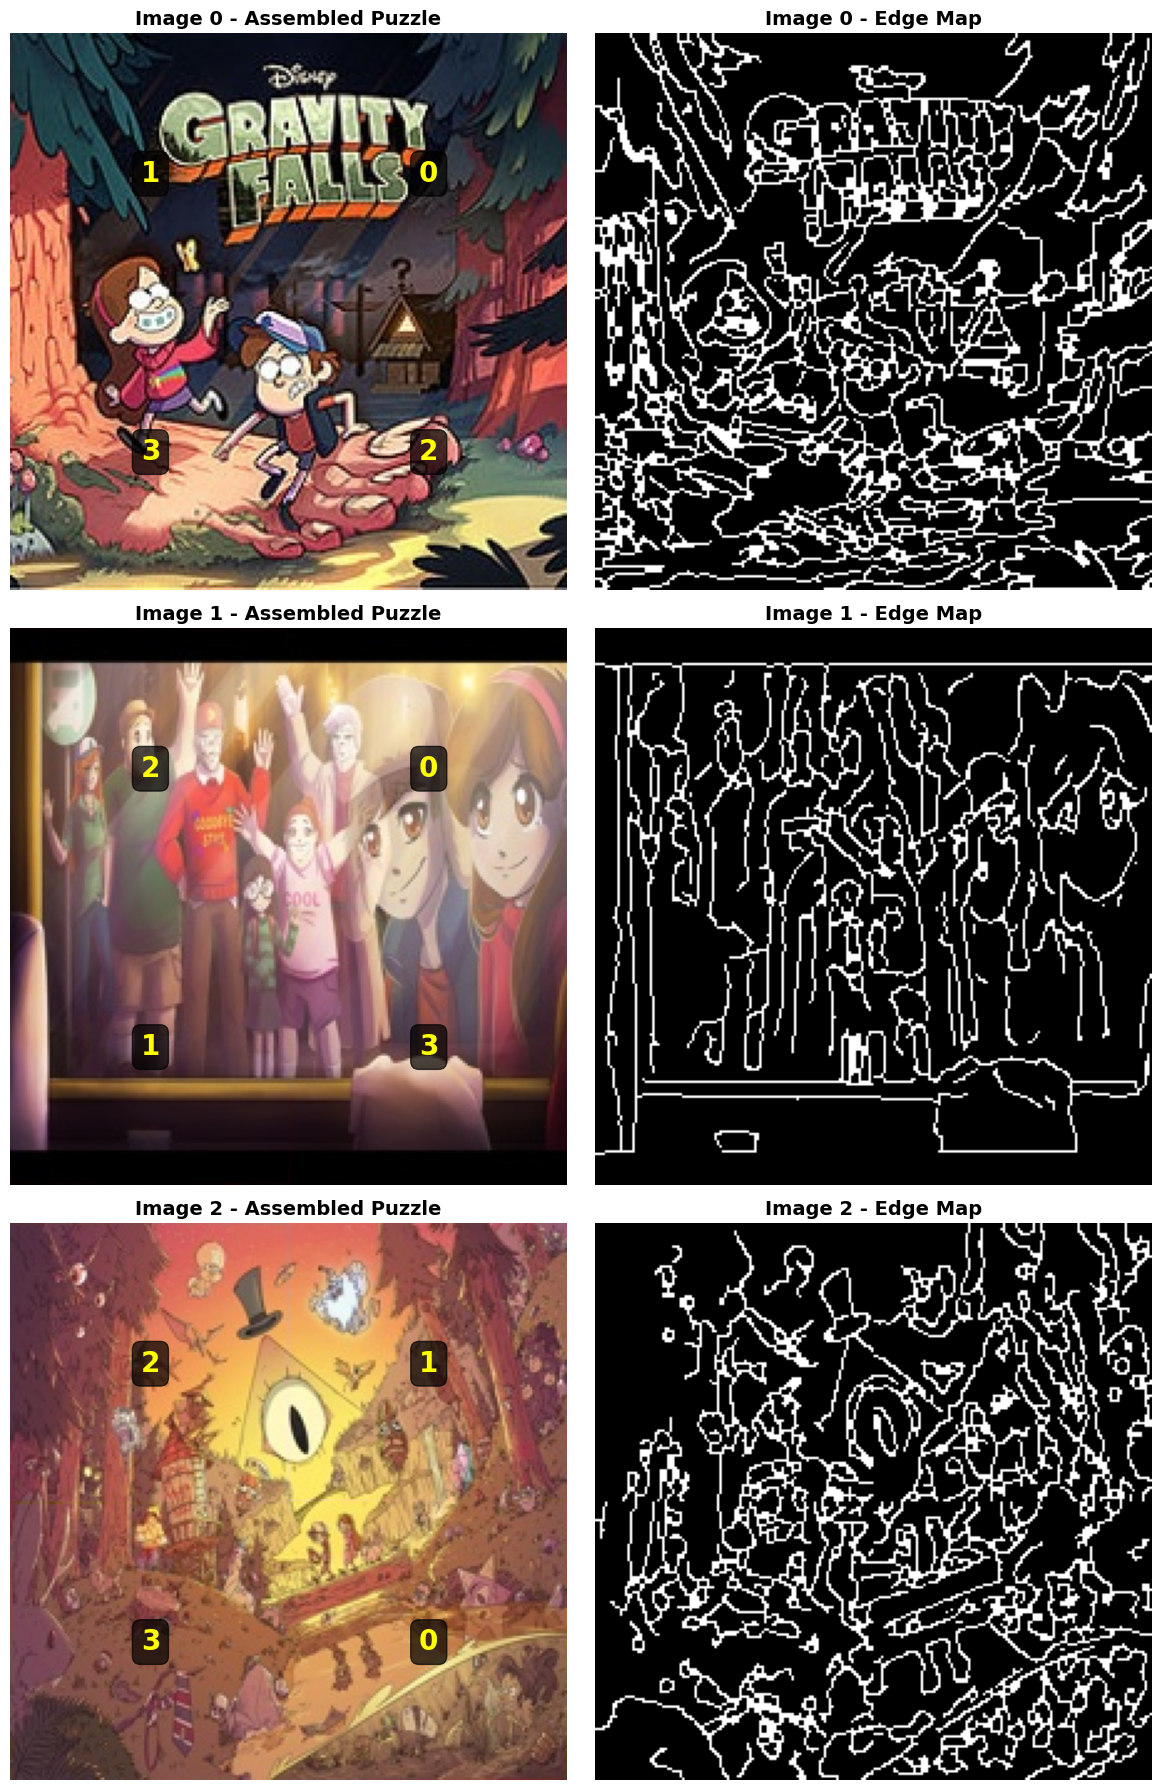


ASSEMBLY SUMMARY

Image 0:
  Grid: [[1, 0], [3, 2]]
  Score: 4.0391

Image 1:
  Grid: [[2, 0], [1, 3]]
  Score: 5.9013

Image 2:
  Grid: [[2, 1], [3, 0]]
  Score: 4.0113


In [5]:
def create_assembled_image(grid, patches):
    """Reconstruct full image from assembled grid."""
    grid_size = grid.shape[0]
    
    if len(patches[0].shape) == 3:
        patch_h, patch_w, channels = patches[0].shape
        assembled = np.zeros((grid_size * patch_h, grid_size * patch_w, channels), dtype=np.uint8)
    else:
        patch_h, patch_w = patches[0].shape
        assembled = np.zeros((grid_size * patch_h, grid_size * patch_w), dtype=np.uint8)
    
    for row in range(grid_size):
        for col in range(grid_size):
            piece_idx = grid[row, col]
            if piece_idx >= 0:
                y_start = row * patch_h
                y_end = (row + 1) * patch_h
                x_start = col * patch_w
                x_end = (col + 1) * patch_w
                assembled[y_start:y_end, x_start:x_end] = patches[piece_idx]
    
    return assembled

# Visualize all results
num_images = len(all_results)
fig, axes = plt.subplots(num_images, 2, figsize=(12, 6 * num_images))

if num_images == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(all_results):
    assembled_image = create_assembled_image(result['assembled_grid'], result['original_patches'])
    assembled_edges = create_assembled_image(result['assembled_grid'], result['edge_images'])
    
    # Show assembled image
    axes[idx, 0].imshow(assembled_image)
    axes[idx, 0].set_title(f"Image {result['image_id']} - Assembled Puzzle", fontsize=14, fontweight='bold')
    axes[idx, 0].axis('off')
    
    # Add piece labels
    for row in range(result['grid_size']):
        for col in range(result['grid_size']):
            piece_idx = result['assembled_grid'][row, col]
            patch_h, patch_w = result['original_patches'][0].shape[:2]
            y = (row + 0.5) * patch_h
            x = (col + 0.5) * patch_w
            axes[idx, 0].text(x, y, str(piece_idx), 
                        color='yellow', fontsize=20, fontweight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    # Show edge map
    axes[idx, 1].imshow(assembled_edges, cmap='gray')
    axes[idx, 1].set_title(f"Image {result['image_id']} - Edge Map", fontsize=14, fontweight='bold')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("ASSEMBLY SUMMARY")
print("="*60)
for result in all_results:
    print(f"\nImage {result['image_id']}:")
    print(f"  Grid: {result['assembled_grid'].tolist()}")
    print(f"  Score: {result['assembly_score']:.4f}")

## Summary

This notebook demonstrates Phase 2 puzzle assembly using:

**Algorithm Components:**
- **Hybrid Compatibility Matrix**: Combines edge structure (30%) and pixel boundary matching (70%)
- **Exhaustive Search**: For 2x2 puzzles, tests all 24 permutations to find globally optimal arrangement

**Key Functions:**
- `build_hybrid_compatibility_matrix()` - Creates compatibility scores using edge and pixel features
- `assemble_exhaustive_2x2()` - Finds best arrangement by testing all possibilities

This approach successfully assembles 2x2 puzzles by leveraging both Phase 1 edge detection artifacts and raw pixel information.